# House Prices: Advanced Regression Techniques
Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

_Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)_

## Table of Contents <a name='table'></a>
- [Load Data](#Load-Data)
- [Find 'Na' Values](#na)
  - [Explore 'Na' Values](#cleanNa)
  - [Fill 'Na' Values](#fillNa)

***

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load Data <a name='Load-Data'></a>
[Table of Cotents](#table)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.shape

(1460, 81)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Find 'NA' Values <a name ='findNa'></a>
[Table of Contents](#table)

<AxesSubplot:>

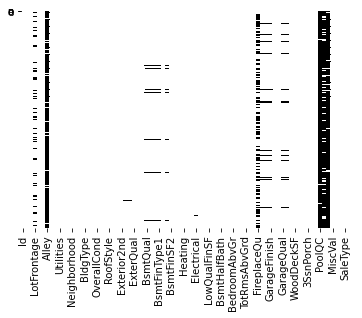

In [5]:
sns.heatmap(train_data.isna(),cmap='binary', cbar=False, yticklabels='none')

In [6]:
na_sum = train_data.isna().sum().sort_values(ascending=False)
print(na_sum.loc[na_sum >= 1])
print(f'Columns with NaN values: {na_sum.loc[na_sum >= 1].count()}')

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
Columns with NaN values: 19


In [7]:
X_train = train_data.copy()

In [8]:
na_find = X_train.isna().any()
na_values = X_train.loc[:,na_find]
na_col = na_values.columns.tolist()

# train_data.fillna(value=1, axis=1, inplace = True)
# train_data.isna().any()

### Clean 'Na' Values <a name='cleanNa'></a>
[Table of Contents](#table)

In [9]:
na_ratio = na_sum / len(X_train)
na_ratio.sort_values(ascending=False)[:19]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtCond        0.025342
BsmtQual        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [10]:
na_col

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

Dropping columns with over 30% na values.
May come back and turn them into valuable features later.

In [11]:
na_drop = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
X_train.drop(na_drop, axis=1, inplace=True)

for i in na_drop:
    na_col.remove(i)

In [12]:
na_mean =[]
na_median =[]
na_mode =[]

def na_sort(column, sort):
    if column not in na_col:
        return "Column doesn't contain 'Na' values."
        
    elif sort == 'mean':
        na_mean.append(column)
    elif sort == 'median':
        na_median.append(column)
    elif sort == 'mode':
        na_mode.append(column)
    else:
        return 'Unkown sort value'
    
    na_col.remove(column)
    print(na_col)
    print(f'Remaining columns w/ "NA" values {len(na_col)}')
    
    return

In [21]:
def scribe_stats(column, df=X_train):
    if df[column].dtype == 'O':
        df[column].value_counts(normalize=True).plot(kind='bar')
        print(df[column].describe())
        print(f'"Na" value count: {df[column].isna().sum()}')
        print(f'"Na" % missing: {df[column].isna().sum() / len(df[column])}')

    else:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        df[column].hist()
        plt.subplot(1,2,2)
        df[column].plot(kind='box')
        print(f'Median: {df[column].median()},\nMode: {df[column].mode()}, \
        \nSkew: {df[column].skew()}, \nKurtosis: {df[column].kurtosis()}, \
        \n{df[column].describe()} \n"Na" value count: {df[column].isna().sum()} ')
    return

In [22]:
train_data.MasVnrType.dtype

dtype('O')

In [23]:
na_col

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

Median: 69.0,
Mode: 0    60.0
dtype: float64,         
Skew: 2.163569142324884, 
Kurtosis: 17.452867259818404,         
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64 
"Na" value count: 259 


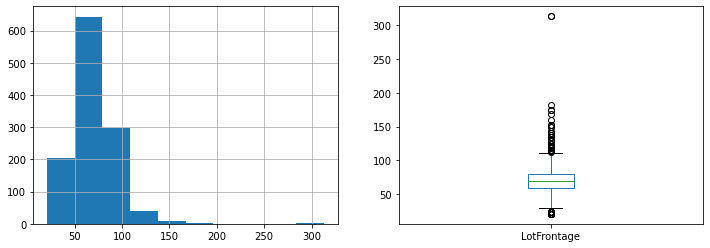

In [24]:
scribe_stats('LotFrontage')

In [ ]:
na_sort('LotFrontage','mean')

In [ ]:
scribe_stats('MasVnrType')

In [ ]:
na_sort('MasVnrType', 'mode')

In [ ]:
scribe_stats('MasVnrArea')

In [ ]:
na_sort('MasVnrArea', 'mean')

In [ ]:
scribe_stats('BsmtQual')

In [ ]:
na_sort('BsmtQual', 'mode')

In [ ]:
scribe_stats('BsmtCond')

In [ ]:
na_sort('BsmtCond', 'mode')

In [ ]:
scribe_stats('BsmtExposure')

In [ ]:
na_sort('BsmtExposure','mode')

In [ ]:
scribe_stats('BsmtFinType1')

In [ ]:
na_sort('BsmtFinType1','mode')

In [ ]:
scribe_stats('BsmtFinType2')

In [ ]:
na_sort('BsmtFinType2','mode')

In [ ]:
scribe_stats('Electrical')

In [ ]:
na_sort('Electrical','mode')

In [ ]:
scribe_stats('GarageType')

In [ ]:
na_sort('GarageType','mode')

In [ ]:
scribe_stats('GarageYrBlt')

In [ ]:
na_sort('GarageYrBlt','mean')

In [ ]:
scribe_stats('GarageFinish')

In [ ]:
na_sort('GarageFinish','mode')

In [ ]:
scribe_stats('GarageQual')

In [ ]:
na_sort('GarageQual','mode')

In [ ]:
scribe_stats('GarageCond')

In [ ]:
na_sort('GarageCond','mode')

### Fill 'Na' Values  <a name='fillNa'></a>
[Table of Contents](#table)

In [ ]:
# mean = X_train[na_mean].mean()
# X_train.loc[:,na_mean].fillna(mean, inplace=True)

# mode = X_train[na_mode].mode()
# X_train.loc[:,na_mode].fillna(mode, inplace=True)

In [ ]:
na_mode

In [ ]:
X_train.isna().sum()

In [ ]:
mean2 = X_train['LotFrontage'].mean()
X_train['LotFrontage'].fillna(mean2, inplace=True)

In [ ]:
train_data.SalePrice.hist()

In [ ]:
cont_labels = ['LotFrontage', 'LotArea', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'SalePrice']

In [ ]:
def cont_scatter(df, compare, sale_price=train_data.SalePrice):
    
    plt.figure(figsize=(16,4))
    
    plt.subplot(1,3,1)
    plt.hist(df[compare])
    
    plt.subplot(1,3,2)
    plt.scatter(df[compare], sale_price)
    
    plt.subplot(1,3,3)
    plt.boxplot(df[compare])
    print(f'Median: {df[compare].median()},\nMode: {df[compare].mode()}, \
    \nSkew: {df[compare].skew()}, \nKurtosis: {df[compare].kurtosis()}, \n{df[compare].describe()}')

In [ ]:
cont_scatter(train_data,'LotArea')